# Forest biomass model (constant forcing)

We want to solve the system
\begin{align}
x' &= - x + 3y, \\
y' &= - 3y + 5z, \\
z' &= - 5z + Z_f.
\end{align}
The eigenvalues are $-1$, $-3$, and $-5$. The change of coordinate matrix made of the eigenvectors is
\begin{equation}
P = \begin{pmatrix} 1 & 3 & 15 \\ 0 & 2 & -20 \\ 0 & 0 & 8 \end{pmatrix},
\end{equation}
which inverse reads
\begin{equation}
P^{-1} = \begin{pmatrix} 1 & -\frac32 & -\frac{45}8 \\ 0 & \frac12 & \frac54 \\ 0 & 0 & \frac18 \end{pmatrix}.
\end{equation}
Therefore
\begin{equation}
\exp(tA) 
= P \begin{pmatrix} e^{-t} & 0 & 0 \\ 0 & e^{-3t} & 0 \\ 0 & 0 & e^{-5t} \end{pmatrix} P^{-1}
= \begin{pmatrix} e^{-t} & \frac32e^{-t}-\frac32e^{-3t} & \frac{15}8e^{-t}-\frac{15}4e^{-3t}+\frac{15}8e^{-5t} \\ 0 & e^{-3t} & \frac52e^{-3t}-\frac52e^{-5t} \\ 0 & 0 & e^{-5t} \end{pmatrix}.
\end{equation}
We will take $(0,0,z_0)$ as initial data (only living trees).

## Exact solution

\begin{align}
x(t) &= \frac{15}8(e^{-t}-2e^{-3t}+e^{-5t})z_0 + \frac18(8-15e^{-t}+10e^{-3t}-3e^{-5t})Z_f, \\
y(t) &= \frac52(e^{-3t}-e^{-5t})z_0 + \frac16(2-5e^{-3t}+3e^{-5t})Z_f, \\
z(t) &= e^{-5t}z_0 + \frac15(1-e^{-5t})Z_f.
\end{align}

In [1]:
%matplotlib inline
from math import exp
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

def exact(z0, Zf, T):
    exp1 = np.exp(-T)
    exp3 = np.exp(-3*T)
    exp5 = np.exp(-5*T)
    X = 1.875 * (exp1 - 2 * exp3 + exp5) * z0 \
    + 0.125 * (8 - 15 * exp1 + 10 * exp3 - 3 * exp5) * Zf
    Y = 2.5 * (exp3 - exp5) * z0 + (2 - 5 * exp3 + 3 * exp5) / 6 * Zf
    Z = exp5 * z0 + .2 * (1 - exp5) * Zf
    return X, Y, Z

In [2]:
A = np.array([[-1, 3, 0], [0, -3, 5],[0, 0, -5]])
vp, P = np.linalg.eig(A)
print(P)
invP = np.linalg.inv(P)
print(invP)
print(np.linalg.inv(A))

[[ 1.         -0.83205029  0.57145449]
 [ 0.          0.5547002  -0.76193932]
 [ 0.          0.          0.30477573]]
[[1.         1.5        1.875     ]
 [0.         1.80277564 4.50693909]
 [0.         0.         3.28110119]]
[[-1.         -1.         -1.        ]
 [-0.         -0.33333333 -0.33333333]
 [-0.         -0.         -0.2       ]]


## Data for tests

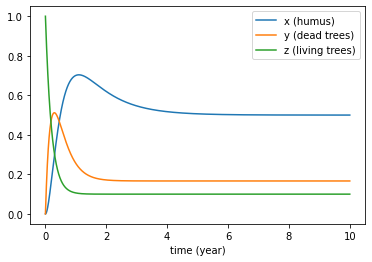

In [3]:
Tmax = 10
dt = .001
n = int(Tmax / dt)
T = dt * np.array(range(n+1))
z0, Zf = 1, .5
XYZExact = exact(z0, Zf, T)

plt.plot(T, XYZExact[0], label="x (humus)")
plt.plot(T, XYZExact[1], label="y (dead trees)")
plt.plot(T, XYZExact[2], label="z (living trees)")
plt.xlabel('time (year)')
plt.legend()
plt.savefig('Plots/Trees_exact.png', format='png')
plt.savefig('Plots/Trees_exact.pdf', format='pdf')

## Explicit Euler

\begin{align}
x_{k+1} &= (1 - \Delta t) x_k + 3\Delta t y_k, \\
y_{k+1} &= (1 - 3\Delta t) y_k + 5\Delta t z_k, \\
z_{k+1} &= (1 - 5\Delta t) z_k + \Delta t Z_f.
\end{align}

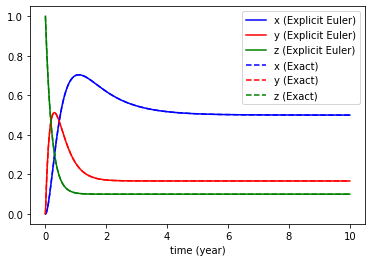

In [4]:
def xyz_explicit_Euler(z0, Zf, dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n):
        Z[i+1] = (1 - 5 * dt) * Z[i] + dt * Zf
        Y[i+1] = (1 - 3 * dt) * Y[i] + 5 * dt * Z[i]
        X[i+1] = (1 - dt) * X[i] + 3 * dt * Y[i]
    return X, Y, Z
        
XYZEulerE = xyz_explicit_Euler(z0, Zf, dt, Tmax)
plt.plot(T, XYZEulerE[0] ,'b', label="x (Explicit Euler)")
plt.plot(T, XYZEulerE[1] ,'r', label="y (Explicit Euler)")
plt.plot(T, XYZEulerE[2] ,'g', label="z (Explicit Euler)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Implicit Euler

\begin{align}
x_{k+1} &= \frac1{1 + \Delta t} (x_k + 3\Delta t y_{k+1}), \\
y_{k+1} &= \frac1{1 + 3\Delta t} (y_k + 5\Delta t z_{k+1}), \\
z_{k+1} &= \frac1{1 + 5\Delta t} (z_k + \Delta t Z_f).
\end{align}

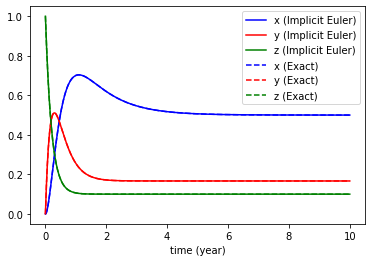

In [5]:
def xyz_implicit_Euler(z0, Zf, dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n):        
        Z[i+1] = (Z[i] + dt * Zf) / (1 + 5 * dt)
        Y[i+1] = (Y[i] + 5 * dt * Z[i+1]) / (1 + 3 * dt)
        X[i+1] = (X[i] + 3 * dt * Y[i+1]) / (1 + dt)
    return X, Y, Z
        
XYZEulerI = xyz_implicit_Euler(z0, Zf, dt, Tmax)
plt.plot(T, XYZEulerI[0] ,'b', label="x (Implicit Euler)")
plt.plot(T, XYZEulerI[1] ,'r', label="y (Implicit Euler)")
plt.plot(T, XYZEulerI[2] ,'g', label="z (Implicit Euler)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Our scheme

\begin{align}
\alpha_0(\Delta t) & = \frac{15}8 e^{-\Delta t} - \frac54 e^{-3\Delta t} + \frac38 e^{-5\Delta t},\\
\alpha_1(\Delta t) & = e^{-\Delta t} - \frac32 e^{-3\Delta t} + \frac12 e^{-5\Delta t},\\
\alpha_2(\Delta t) & = \frac18 e^{-\Delta t} - \frac14 e^{-3\Delta t} + \frac18 e^{-5\Delta t}.
\end{align}
\begin{equation}
X_{k+1} = (\alpha_0(\Delta t) + \alpha_1(\Delta t) A + \alpha_2(\Delta t) A^2)(X_k+A^{-1}Z_f) - A^{-1}Z_f.
\end{equation}

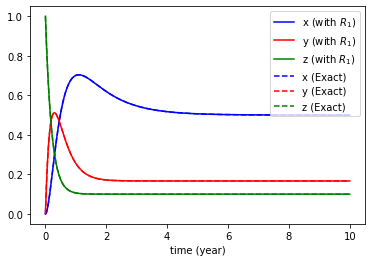

In [6]:
def xyz_NSFD(z0, Zf, dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    exp1 = exp(-dt)
    exp3 = exp(-3*dt)
    exp5 = exp(-5*dt)
    alpha0 = 1.875 * exp1 - 1.25 * exp3 + 0.375 * exp5
    alpha1 = exp1 - 1.5 * exp3 + .5 * exp5
    alpha2 = .125  * exp1 - .25 * exp3 + .125 * exp5
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n):
        Z[i+1] = (alpha0 - 5*alpha1 + 25*alpha2) * (Z[i] - Zf/5) + Zf/5 
        Y[i+1] = (alpha0 - 3*alpha1 + 9*alpha2) * (Y[i] - Zf/3) \
        + (5*alpha1 - 40*alpha2) * (Z[i] - Zf/5) + Zf/3
        X[i+1] = (alpha0 - alpha1 + alpha2) * (X[i] - Zf) \
        + (3*alpha1 - 12*alpha2) * (Y[i] - Zf/3) + 15*alpha2 * (Z[i] - Zf/5) + Zf
    return X, Y, Z
        
XYZNSFD = xyz_NSFD(z0, Zf, dt, Tmax)
plt.plot(T, XYZNSFD[0] ,'b', label="x (with $R_1$)")
plt.plot(T, XYZNSFD[1] ,'r', label="y (with $R_1$)")
plt.plot(T, XYZNSFD[2] ,'g', label="z (with $R_1$)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend(loc='upper right');

Let us replace the $\alpha_j$ by their order 3 approximation.
\begin{align}
\beta_0(\Delta t) & = \frac{15}8 e^{-\Delta t} - \frac54 e^{-3\Delta t} + \frac38 e^{-5\Delta t},\\
\beta_1(\Delta t) & = e^{-\Delta t} - \frac32 e^{-3\Delta t} + \frac12 e^{-5\Delta t},\\
\beta_2(\Delta t) & = \frac18 e^{-\Delta t} - \frac14 e^{-3\Delta t} + \frac18 e^{-5\Delta t}.
\end{align}

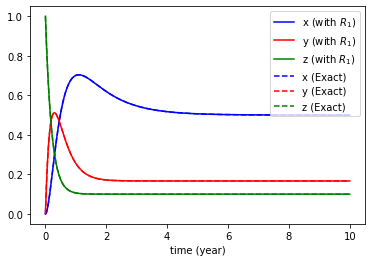

In [7]:
def xyz_NSFD2(z0, Zf, dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    beta0 = 1 - 2.5 * dt * dt * dt
    beta1 = dt - 23/6 * dt * dt * dt
    beta2 = .5 * dt * dt - 1.5 * dt *dt * dt
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n):  
        Z[i+1] = (beta0 - 5*beta1 + 25*beta2) * (Z[i] - Zf/5) + Zf/5 
        Y[i+1] = (beta0 - 3*beta1 + 9*beta2) * (Y[i] - Zf/3) \
        + (5*beta1 - 40*beta2) * (Z[i] - Zf/5) + Zf/3
        X[i+1] = (beta0 - beta1 + beta2) * (X[i] - Zf) \
        + (3*beta1 - 12*beta2) * (Y[i] - Zf/3) + 15*beta2 * (Z[i] - Zf/5) + Zf
    return X, Y, Z
        
XYZNSFD2 = xyz_NSFD2(z0, Zf, dt, Tmax)
plt.plot(T, XYZNSFD2[0] ,'b', label="x (with $R_1$)")
plt.plot(T, XYZNSFD2[1] ,'r', label="y (with $R_1$)")
plt.plot(T, XYZNSFD2[2] ,'g', label="z (with $R_1$)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend(loc='upper right');

## Mickens' scheme

We apply the general procedure for each equation separately. This yields
\begin{align}
x_{k+1} &= x_k + (1-e^{-\Delta t}) (- x_k + 3 y_k), \\
y_{k+1} &= y_k + \frac{1-e^{-3\Delta t}}3 (- 3 y_k + 5 z_k), \\
z_{k+1} &= z_k + \frac{1-e^{-5\Delta t}}5 (-5 z_k + Z_f).
\end{align}

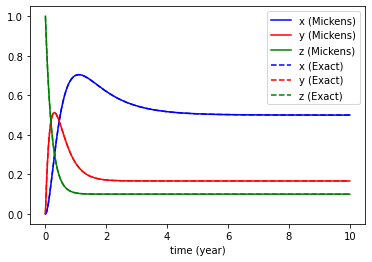

In [8]:
def xyz_Mickens(z0, Zf, dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    dtx = 1 - exp(-dt)
    dty = (1 - exp(-3*dt)) / 3
    dtz = (1 - exp(-5*dt)) / 5
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = z0
    for i in range(n):
        Z[i+1] = Z[i] + dtz * (-5 * Z[i] + Zf)
        Y[i+1] = Y[i] + dty * (-3 * Y[i] + 5 * Z[i])
        X[i+1] = X[i] + dtx * (- X[i] + 3 * Y[i])
    return X, Y, Z
        
XYZMickens = xyz_Mickens(z0, Zf, dt, Tmax)
plt.plot(T, XYZMickens[0] ,'b', label="x (Mickens)")
plt.plot(T, XYZMickens[1] ,'r', label="y (Mickens)")
plt.plot(T, XYZMickens[2] ,'g', label="z (Mickens)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Error analysis

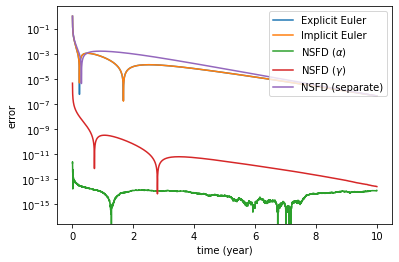

In [9]:
ErrorEulerE = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZEulerE[0][1:], XYZExact[0][1:])])
ErrorEulerI = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZEulerI[0][1:], XYZExact[0][1:])])
ErrorNSFD = np.array([abs((x - xe) / xe) \
                      for x, xe in zip(XYZNSFD[0][1:], XYZExact[0][1:])])
ErrorNSFD2 = np.array([abs((x - xe) / xe) \
                       for x, xe in zip(XYZNSFD2[0][1:], XYZExact[0][1:])])
ErrorMickens = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZMickens[0][1:], XYZExact[0][1:])])

plt.semilogy(T[1:], ErrorEulerE, label="Explicit Euler")
plt.semilogy(T[1:], ErrorEulerI, label="Implicit Euler")
plt.semilogy(T[1:], ErrorNSFD, label=r"NSFD ($\alpha$)")
plt.semilogy(T[1:], ErrorNSFD2, label=r"NSFD ($\gamma$)")
plt.semilogy(T[1:], ErrorMickens, label="NSFD (separate)")
plt.xlabel("time (year)")
plt.ylabel('error')
plt.legend(loc='upper right');

In [10]:
I = np.eye(3,3)
A = np.array([[-1, 3, 0], [0, -3, 5],[0, 0, -5]])
A2 = A @ A
exp1 = exp(-dt)
exp2 = exp(-2*dt)
exp3 = exp(-3*dt)
exp5 = exp(-5*dt)
expdtA = np.array([[exp1, 1.5 * exp1 - 1.5 * exp3, 1.875 * exp1 - 3.75 * exp3 + 1.875 * exp5],
                 [0, exp3, 2.5 * exp3 - 2.5 * exp5], [0, 0, exp5]])
print(expdtA)
alpha0 = 1.875 * exp1 - 1.25 * exp3 + 0.375 * exp5
alpha1 = exp1 - 1.5 * exp3 + .5 * exp5
alpha2 = .125  * exp1 - .25 * exp3 + .125 * exp5
expdtAbis = alpha0 * I + alpha1 * A + alpha2 * A2
print(expdtAbis)
beta0 = 1 - 2.5 * dt * dt * dt
beta1 = dt - 23/6 * dt * dt * dt
beta2 = .5 * dt * dt - 1.5 * dt *dt * dt
expdtAter = beta0 * I + beta1 * A + beta2 * A2
print(expdtAter)

[[9.99000500e-01 2.99400650e-03 7.47753621e-06]
 [0.00000000e+00 9.97004496e-01 4.98004078e-03]
 [0.00000000e+00 0.00000000e+00 9.95012479e-01]]
[[9.99000500e-01 2.99400650e-03 7.47753621e-06]
 [0.00000000e+00 9.97004496e-01 4.98004078e-03]
 [0.00000000e+00 0.00000000e+00 9.95012479e-01]]
[[9.99000500e-01 2.99400650e-03 7.47750000e-06]
 [0.00000000e+00 9.97004495e-01 4.98004083e-03]
 [0.00000000e+00 0.00000000e+00 9.95012479e-01]]


## Order analysis

In [11]:
def Error(XYZ, dt, norm):
    XError = np.linalg.norm(XYZ[0] - XYZExact[0], ord=norm)
    YError = np.linalg.norm(XYZ[1] - XYZExact[1], ord=norm)
    ZError = np.linalg.norm(XYZ[2] - XYZExact[2], ord=norm)
    return dt*XError + dt*YError + dt*ZError

[[1.99455427e-01 1.53632625e-01 1.65978342e-15 5.44131393e-03
  3.26879397e-01]
 [9.28289143e-02 8.16825752e-02 1.71737624e-15 5.58181376e-04
  1.53760521e-01]
 [1.76004361e-02 1.71570302e-02 1.31145095e-14 3.76983990e-06
  2.92682958e-02]
 [1.73980875e-03 1.73537674e-03 5.56414689e-14 3.62499422e-09
  2.89426041e-03]
 [8.69349444e-04 8.68241300e-04 1.31788832e-13 4.52163634e-10
  1.44622833e-03]]


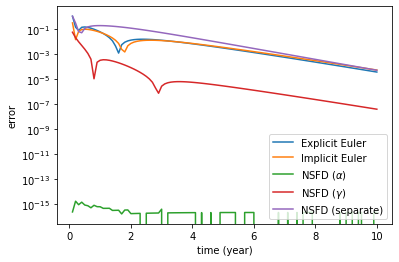

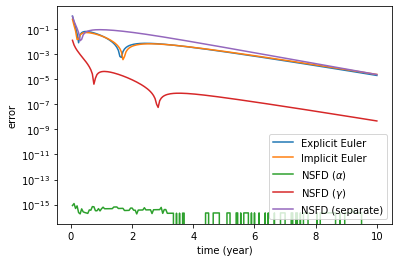

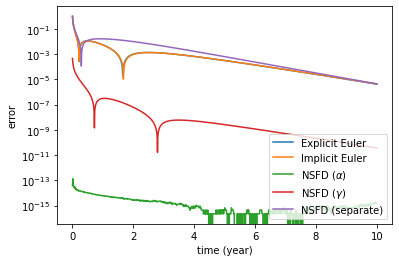

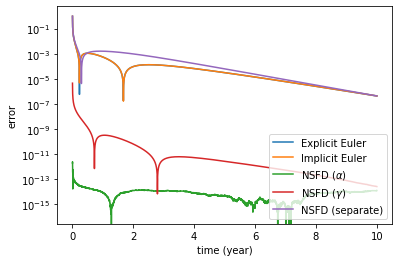

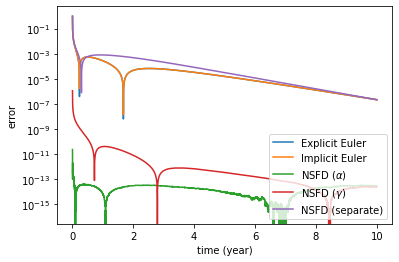

In [12]:
dt_tab = [0.1, 0.05, 0.01, 0.001, 0.0005]
errors = np.zeros((len(dt_tab), 5))
for (j, dt) in enumerate(dt_tab):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    XYZExact = exact(z0, Zf, T)
    XYZEulerE = xyz_explicit_Euler(z0, Zf, dt, Tmax)
    XYZEulerI = xyz_implicit_Euler(z0, Zf, dt, Tmax)
    XYZNSFD = xyz_NSFD(z0, Zf, dt, Tmax)
    XYZNSFD2 = xyz_NSFD2(z0, Zf, dt, Tmax)
    XYZMickens = xyz_Mickens(z0, Zf, dt, Tmax)
    # Errors
    errors[j,0] = Error(XYZEulerE, dt, 1)
    errors[j,1] = Error(XYZEulerI, dt, 1)
    errors[j,2] = Error(XYZNSFD, dt, 1)
    errors[j,3] = Error(XYZNSFD2, dt, 1)
    errors[j,4] = Error(XYZMickens, dt, 1)
    # Plots
    plt.figure(j)
    ErrorEulerE = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZEulerE[0][1:], XYZExact[0][1:])])
    ErrorEulerI = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZEulerI[0][1:], XYZExact[0][1:])])
    ErrorNSFD = np.array([abs((x - xe) / xe) \
              for x, xe in zip(XYZNSFD[0][1:], XYZExact[0][1:])])
    ErrorNSFD2 = np.array([abs((x - xe) / xe) \
               for x, xe in zip(XYZNSFD2[0][1:], XYZExact[0][1:])])
    ErrorMickens = np.array([abs((x - xe) / xe) \
                 for x, xe in zip(XYZMickens[0][1:], XYZExact[0][1:])])
    plt.semilogy(T[1:], ErrorEulerE, label="Explicit Euler")
    plt.semilogy(T[1:], ErrorEulerI, label="Implicit Euler")
    plt.semilogy(T[1:], ErrorNSFD, label=r"NSFD ($\alpha$)")
    plt.semilogy(T[1:], ErrorNSFD2, label=r"NSFD ($\gamma$)")
    plt.semilogy(T[1:], ErrorMickens, label="NSFD (separate)")
    plt.xlabel("time (year)")
    plt.ylabel('error')
    plt.legend(loc='lower right')
    plt.savefig('Plots/Trees_'+str(dt_tab[j])[2:]+'.png', format='png')
    plt.savefig('Plots/Trees_'+str(dt_tab[j])[2:]+'.pdf', format='pdf')
print(errors)

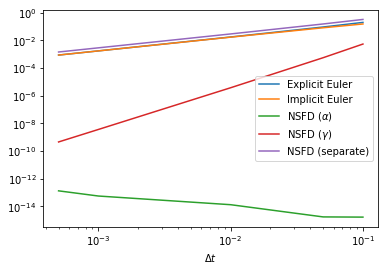

In [13]:
methods_tab = ['Explicit Euler', 'Implicit Euler',
               r'NSFD ($\alpha$)', r'NSFD ($\gamma$)', 
               'NSFD (separate)']
plt.loglog(dt_tab,errors)
plt.xlabel(r'$\Delta t$')
plt.legend(methods_tab)
plt.savefig('Plots/Trees_orders.png', format='png')
plt.savefig('Plots/Trees_orders.pdf', format='pdf')

In [14]:
orders = [linregress(np.log(dt_tab),np.log(errors[:,k])).slope for k in range(5)]
for (method,order) in zip(methods_tab,orders):
    print(method, ':', order)

Explicit Euler : 1.022035502421645
Implicit Euler : 0.9801155257935014
NSFD ($\alpha$) : -0.8431812525362965
NSFD ($\gamma$) : 3.0669244548124537
NSFD (separate) : 1.0198841341280211
